<div style="background: linear-gradient(135deg, #0f2027, #203a43, #2c5364); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3);">
    <h1 style="color: #ff6f61; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 30px; margin-bottom: 15px;">
        Fruit & Vegetable Disease Detection
    </h1>
    <p style="color: #f0f0f0; font-family: 'Helvetica Neue', sans-serif; font-size: 18px; text-align: center; line-height: 1.6;">
        In this project, we explore a comprehensive dataset on <strong>Fruit and Vegetable Diseases (Healthy vs Rotten)</strong> 
        using three state-of-the-art deep learning models: <strong>EfficientNet</strong>, <strong>ResNet</strong>, and <strong>MobileNet</strong>. 
        Our objective is to evaluate and compare these models to determine which one most effectively distinguishes between healthy and rotten produce.
        Through rigorous training, fine-tuning, and error analysis, we aim to deliver robust and reliable predictions for real-world applications in food quality and safety.
    </p>
</div>


<div style="background: linear-gradient(135deg, #2c3e50, #4ca1af); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #e74c3c; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        Model Comparison & Evaluation
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        After rigorous experiments and error analysis, our study reveals distinct strengths among the models.
        <strong>ResNet</strong> demonstrates superior accuracy on complex cases,
        <strong>EfficientNet</strong> achieves an optimal balance between speed and precision,
        and <strong>MobileNet</strong> excels in efficiency, making it ideal for resource-limited applications.
        This comprehensive evaluation informs the selection of the best model for reliable food quality and safety assessment.
    </p>
</div>


# 🚀 1. Importing Libraries  



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B0
from tensorflow.keras import layers, models, optimizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import os
import random

In [2]:
data_dir = "/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten/Fruit And Vegetable Diseases Dataset/"

# 2.Exploratory Data Analysis: Class Distribution and Random Sample Visualization


In [3]:
class_names =sorted(os.listdir(data_dir))
n_classes = len(class_names)
class_dis = [len(os.listdir(data_dir + i)) for i in class_names]
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 28 
Class Names : ['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten']


In [4]:
fig = px.pie(names = class_names , values = class_dis, 
             title="Training class Distribution",hole = 0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

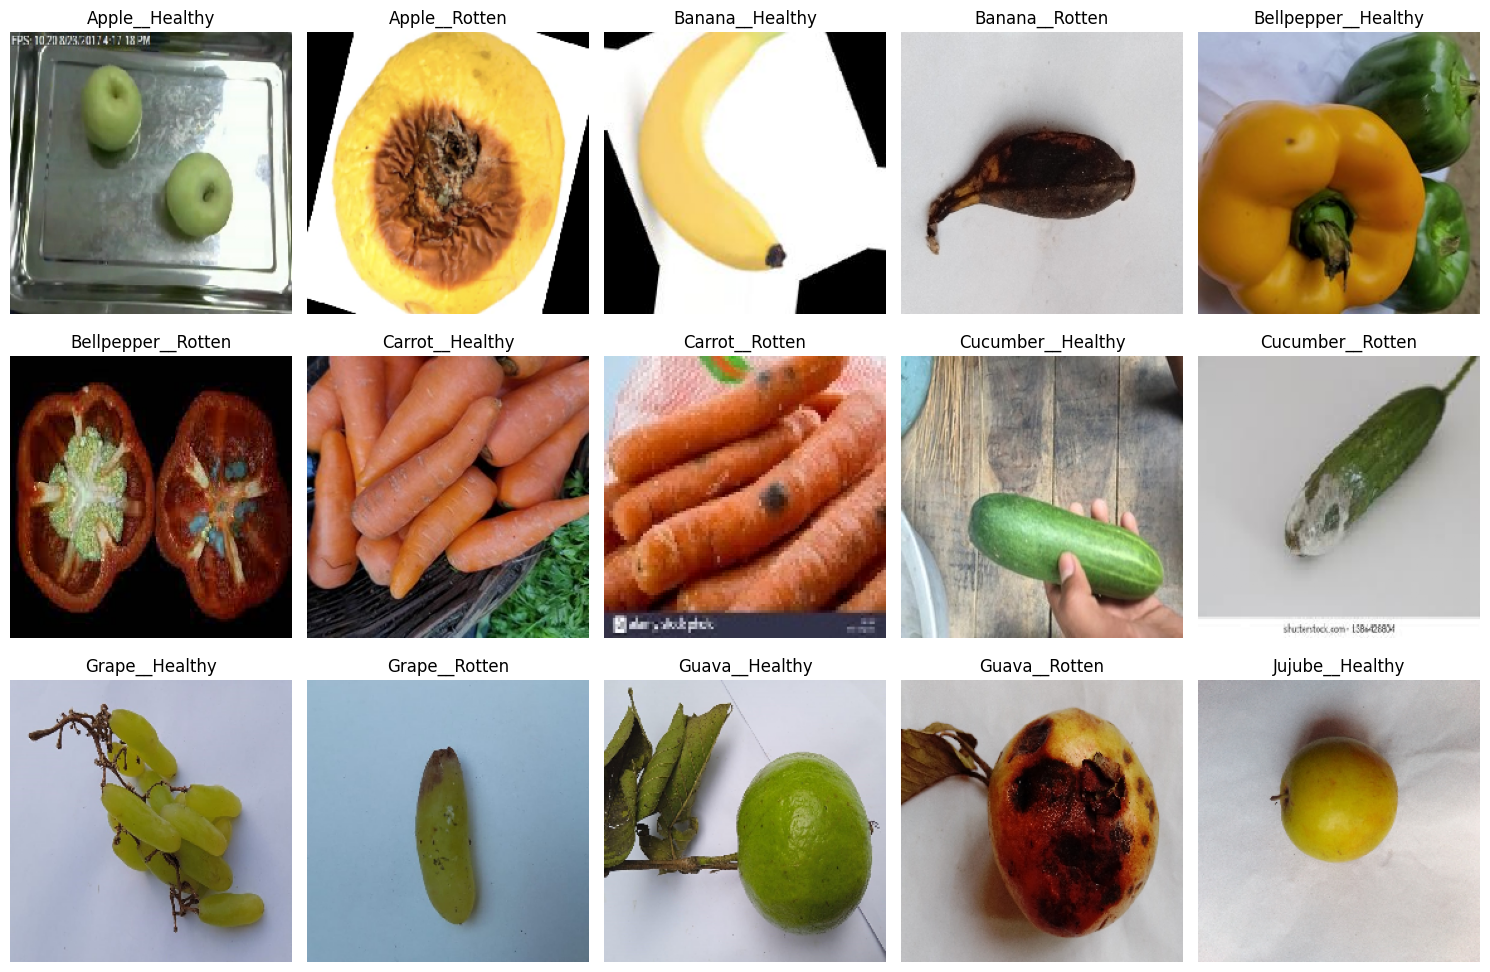

In [5]:
# Generate a random image from each class
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names[:15]):  # Display only the first 15 classes
    class_path = os.path.join(data_dir, class_name)
    
    # Select a random file from this class
    image_file = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_file)

    # Load the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize

    # Display the image
    plt.subplot(3, 5, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(class_name)

plt.tight_layout()
plt.show()


# 3.Data Preparation: Creating Training and Validation Sets


<div style="background: linear-gradient(135deg, #34495e, #2c3e50); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #f39c12; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        🔄 Data Preprocessing with ImageDataGenerator
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        The <strong>ImageDataGenerator</strong> is used to preprocess the dataset by rescaling pixel values 
        and splitting the data into training and validation sets. 
        It helps improve model generalization and prevents overfitting.
    </p>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; margin-top: 10px;">
        ✅ You can also customize it with parameters like:
    </p>
    <ul style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; list-style: none; padding: 0;">
        <li>📌 <strong>rotation_range=40</strong> → Randomly rotates images</li>
        <li>📌 <strong>width_shift_range=0.2</strong> → Shifts images horizontally</li>
        <li>📌 <strong>height_shift_range=0.2</strong> → Shifts images vertically</li>
        <li>📌 <strong>zoom_range=0.2</strong> → Applies random zoom</li>
        <li>📌 <strong>horizontal_flip=True</strong> → Flips images horizontally</li>
    </ul>
</div>


In [ ]:
"""
rotation_range=30,
width_shift_range=0.3,
height_shift_range=0.3,
shear_range=0.3,
zoom_range=0.3,
brightness_range=[0.7, 1.3],
horizontal_flip=True,
vertical_flip=True, 
fill_mode='nearest',
"""

In [67]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25 0.3 or 0.2
)

In [68]:
batch_size = 64
img_size = (224, 224)

In [69]:
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

valid_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset="validation"
)

Found 21967 images belonging to 28 classes.
Found 7310 images belonging to 28 classes.


In [14]:
print(f"Classes: {train_data.class_indices}")
print(f"Train samples: {train_data.samples}, Valid samples: {valid_data.samples}")

Classes: {'Apple__Healthy': 0, 'Apple__Rotten': 1, 'Banana__Healthy': 2, 'Banana__Rotten': 3, 'Bellpepper__Healthy': 4, 'Bellpepper__Rotten': 5, 'Carrot__Healthy': 6, 'Carrot__Rotten': 7, 'Cucumber__Healthy': 8, 'Cucumber__Rotten': 9, 'Grape__Healthy': 10, 'Grape__Rotten': 11, 'Guava__Healthy': 12, 'Guava__Rotten': 13, 'Jujube__Healthy': 14, 'Jujube__Rotten': 15, 'Mango__Healthy': 16, 'Mango__Rotten': 17, 'Orange__Healthy': 18, 'Orange__Rotten': 19, 'Pomegranate__Healthy': 20, 'Pomegranate__Rotten': 21, 'Potato__Healthy': 22, 'Potato__Rotten': 23, 'Strawberry__Healthy': 24, 'Strawberry__Rotten': 25, 'Tomato__Healthy': 26, 'Tomato__Rotten': 27}
Train samples: 24897, Valid samples: 4380


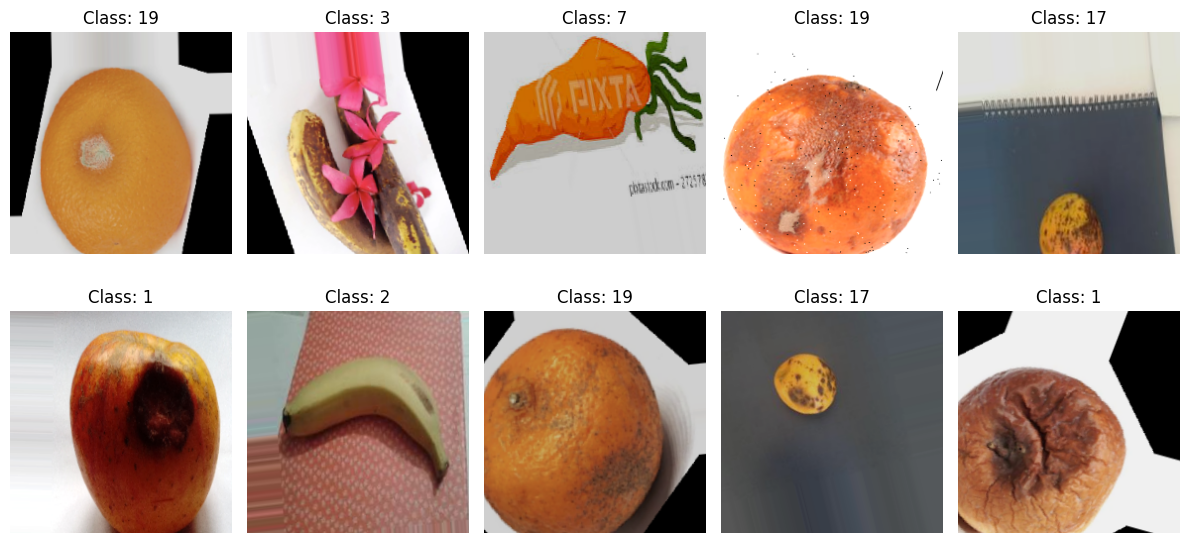

In [21]:
images, labels = next(train_data)  # Get a batch of images

# Display the first 10 images from this batch
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])  # Show image
    plt.axis("off")  # Remove axis
    plt.title(f"Class: {np.argmax(labels[i])}")  # Display image class

plt.tight_layout()
plt.show()


# 4. Building the EfficientNetV2B0 Model 🚀


<div style="background: linear-gradient(135deg, #1a1a2e, #16213e); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #00c8ff; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        🚀 EfficientNetV2B0: Optimized for Speed & Accuracy
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        <strong>EfficientNetV2B0</strong> is a compact and highly efficient deep learning model designed for 
        <strong>image classification</strong>. It improves upon its predecessor (EfficientNetV1) by utilizing 
        <strong>progressive learning</strong>, <strong>faster training</strong>, and <strong>better efficiency</strong> 
        in handling real-world datasets.
    </p>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; margin-top: 10px;">
        ✅ Key Features:
    </p>
    <ul style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; list-style: none; padding: 0;">
        <li>⚡ <strong>Lightweight</strong> → Faster inference and training</li>
        <li>🎯 <strong>Higher Accuracy</strong> → Optimized for complex patterns</li>
        <li>🔥 <strong>Better Scaling</strong> → Efficiently scales to larger datasets</li>
        <li>🧠 <strong>Pretrained on ImageNet</strong> → Transfer learning ready</li>
    </ul>
</div>


<div style="background: linear-gradient(135deg, #1a1a2e, #16213e); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #00c8ff; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        🏗️ Constructing the EfficientNetV2B0 Model 🚀
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        We integrate <strong>EfficientNetV2B0</strong> as the backbone with pre-trained <strong>ImageNet</strong> weights. 
        The base model is initially <strong>frozen</strong> to retain essential feature representations, while custom dense layers refine classification. 
        A fine-tuning strategy can later be applied to optimize performance for domain-specific tasks.
    </p>
</div>


In [83]:
# 1. Base EfficientNetV2B0 Model with Pretrained Weights
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',  # Use pre-trained weights
    input_shape=(224, 224, 3),
    pooling='avg',
    include_preprocessing=True)


In [85]:
# 2. Base model EfficientNetV2B0 with pre-trained weights
base_model.trainable = False  # Freeze EfficientNet layers


# 3. Keep the last layers of the base model open for Fine-Tuning
#base_model.trainable = False

# 4. Model input
inputs = layers.Input(shape=(224, 224, 3))

# 5. Using the base model
x = base_model(inputs)

x = layers.Dropout(0.1)(x)  # Reduce Dropout to preserve useful information

x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Reduce Regularization
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(28, activation='softmax')(x)  # Output with 28 classes

# 6. Build the model
efficientnet_model = models.Model(inputs, outputs)

# 7. AdamW optimizer with adjustable learning rate
optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher learning rate

# 8. Compile the model
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Display model summary
efficientnet_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 1280)                │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,087,404 (23.22 MB)

 Trainable params: 167,836 (655.61 KB)

 Non-trainable params: 5,919,568 (22.58 MB)

In [81]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


## 4.2  Pre-Fine-Tuning Training for EfficientNetV2B0 🛠️

In [86]:
history_efficientnet = efficientnet_model.fit(
    train_data,
    epochs=5,
    validation_data=valid_data 
)

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 272s 718ms/step - accuracy: 0.0817 - loss: 3.4981 - val_accuracy: 0.0762 - val_loss: 3.1116
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 231s 663ms/step - accuracy: 0.1303 - loss: 3.0520 - val_accuracy: 0.1602 - val_loss: 2.9505
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 224s 640ms/step - accuracy: 0.1383 - loss: 2.9751 - val_accuracy: 0.1291 - val_loss: 3.0012
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 223s 640ms/step - accuracy: 0.1437 - loss: 2.9476 - val_accuracy: 0.0739 - val_loss: 4.2373
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 221s 634ms/step - accuracy: 0.1439 - loss: 2.9337 - val_accuracy: 0.0836 - val_loss: 3.7062


## 4.3  Fine-Tuning EfficientNetV2B0 for Enhanced Accuracy ✅

In [87]:
# Unfreeze EfficientNet Layers for Fine-Tuning
base_model.trainable = True

# Reduce Learning Rate for Fine-Tuning
optimizer = optimizers.AdamW(learning_rate=1e-4)  

# Recompile the Model with a Lower Learning Rate
efficientnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Full Training with Fine-Tuning
efficientnet_model.fit(train_data, validation_data=valid_data, epochs=5)


Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 376s 863ms/step - accuracy: 0.5937 - loss: 1.6231 - val_accuracy: 0.5892 - val_loss: 1.6845
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 229s 656ms/step - accuracy: 0.9399 - loss: 0.3499 - val_accuracy: 0.7951 - val_loss: 0.8293
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 221s 633ms/step - accuracy: 0.9746 - loss: 0.1953 - val_accuracy: 0.9153 - val_loss: 0.4018
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 224s 643ms/step - accuracy: 0.9839 - loss: 0.1423 - val_accuracy: 0.7175 - val_loss: 1.0474
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 234s 670ms/step - accuracy: 0.9912 - loss: 0.1069 - val_accuracy: 0.9207 - val_loss: 0.3332


## 4.4  Model Performance: Accuracy, Errors & Insights 📊

In [89]:
loss, accuracy = efficientnet_model.evaluate(valid_data)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 59s 514ms/step - accuracy: 0.9196 - loss: 0.3365
Validation Accuracy: 0.9207
Validation Loss: 0.3332


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step


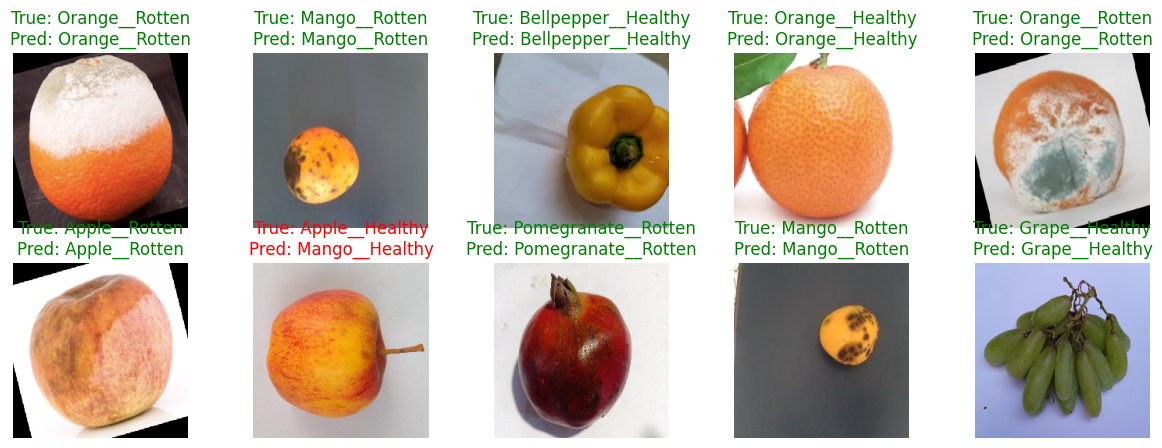

In [95]:
# Fetch a Batch from Validation Data
valid_data.reset()
images, labels = next(valid_data)

# Get Predictions
predictions = efficientnet_model.predict(images)

# Convert Output to Predicted Classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display Images with Predictions
plt.figure(figsize=(15, 5))
for i in range(10):  # Show the first 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = list(valid_data.class_indices.keys())[true_classes[i]]
    pred_label = list(valid_data.class_indices.keys())[predicted_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


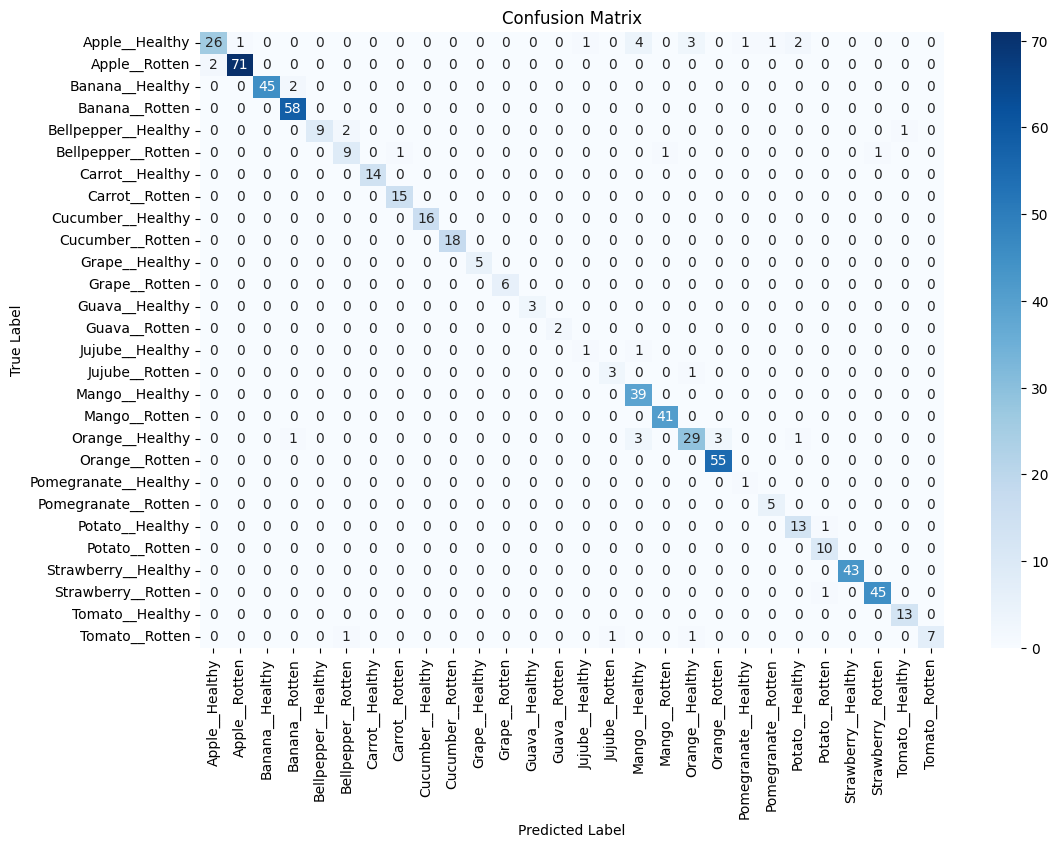

                      precision    recall  f1-score   support

      Apple__Healthy       0.93      0.67      0.78        39
       Apple__Rotten       0.99      0.97      0.98        73
     Banana__Healthy       1.00      0.96      0.98        47
      Banana__Rotten       0.95      1.00      0.97        58
 Bellpepper__Healthy       1.00      0.75      0.86        12
  Bellpepper__Rotten       0.75      0.75      0.75        12
     Carrot__Healthy       1.00      1.00      1.00        14
      Carrot__Rotten       0.94      1.00      0.97        15
   Cucumber__Healthy       1.00      1.00      1.00        16
    Cucumber__Rotten       1.00      1.00      1.00        18
      Grape__Healthy       1.00      1.00      1.00         5
       Grape__Rotten       1.00      1.00      1.00         6
      Guava__Healthy       1.00      1.00      1.00         3
       Guava__Rotten       1.00      1.00      1.00         2
     Jujube__Healthy       0.50      0.50      0.50         2
      J

In [146]:
# Limit the Number of Batches to Prevent High Memory Usage
num_batches = 10  # Number of batches to process

y_pred_probs = []
y_true = []

# Fetch a Limited Number of Batches from valid_data
for i, (images, labels) in enumerate(valid_data):
    if i >= num_batches:  # Restrict processing to 10 batches
        break
    preds = efficientnet_model.predict(images)
    y_pred_probs.append(preds)
    y_true.append(labels)

# Merge All Batches
y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Compute Predicted Classes
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display Classification Report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [148]:
# Calculate Error Rate for Each Class
errors_per_class = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
error_rate_per_class = errors_per_class / np.sum(conf_matrix, axis=1)

# Display Classes with the Highest Error Rate
sorted_errors = sorted(zip(class_names, error_rate_per_class), key=lambda x: x[1], reverse=True)
print("📌 Classes with the Highest Error Rate:")
for cls, error in sorted_errors[:5]:  # Display top 5 classes with the highest error
    print(f"{cls}: {error:.2%} error")


📌 Classes with the Highest Error Rate:
Jujube__Healthy: 50.00% error
Apple__Healthy: 33.33% error
Tomato__Rotten: 30.00% error
Bellpepper__Healthy: 25.00% error
Bellpepper__Rotten: 25.00% error


# 5. Building the ResNet50V2 Model 🔥

<div style="background: linear-gradient(135deg, #2c3e50, #27ae60); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #f1c40f; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        ResNet50V2: Advanced Deep Learning Model
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        ResNet50V2 is an improved version of the original ResNet architecture, designed to tackle the 
        <strong>vanishing gradient problem</strong> in deep networks. By utilizing <strong>residual connections</strong>, it 
        enables efficient feature learning and enhances gradient flow through the network.
        <br><br>
        This model is widely used in <strong>image classification, object detection, and feature extraction</strong>, 
        making it an excellent choice for transfer learning applications. Its deeper architecture allows it to capture 
        intricate patterns in images, leading to superior performance on complex datasets.
    </p>
</div>


<div style="background: linear-gradient(135deg, #34495e, #2ecc71); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #f1c40f; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        Constructing the ResNet50V2 Model 🏗️
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        We leverage <strong>ResNet50V2</strong> as a feature extractor with pre-trained <strong>ImageNet</strong> weights.
        The base model remains <strong>frozen</strong> to preserve learned representations, while custom fully connected layers
        refine the classification process. This architecture ensures a balance between feature richness and computational efficiency.
    </p>
</div>


In [101]:
# 1. Base ResNet50V2 Model with Pretrained Weights
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet'
)

base_model.trainable = False  # Freeze ResNet layers

# 2. Model Input
inputs = layers.Input(shape=(224, 224, 3))

# 3. Utilizing the Base Model
x = base_model(inputs)

x = layers.Dropout(0.1)(x)  # Reduced Dropout to Preserve Useful Information

x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Reduced Regularization
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

# 4. Model Output
outputs = layers.Dense(28, activation='softmax')(x)  # 28-Class Output

# 5. Model Construction
resnet_model = models.Model(inputs, outputs)

# 6. AdamW Optimizer with Adjustable Learning Rate
optimizer = optimizers.AdamW(learning_rate=1e-3)  # Higher Learning Rate

# 7. Model Compilation
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Display Model Summary
resnet_model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,831,196 (90.91 MB)

 Trainable params: 266,140 (1.02 MB)

 Non-trainable params: 23,565,056 (89.89 MB)

## 5.1  Pre-Fine-Tuning Training for ResNet50V2 🛠️

In [102]:
history_ResNet = resnet_model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 302s 809ms/step - accuracy: 0.7489 - loss: 1.1405 - val_accuracy: 0.9097 - val_loss: 0.4765
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 240s 688ms/step - accuracy: 0.9441 - loss: 0.3469 - val_accuracy: 0.9242 - val_loss: 0.3918
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 234s 671ms/step - accuracy: 0.9562 - loss: 0.2753 - val_accuracy: 0.9135 - val_loss: 0.4367
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 240s 690ms/step - accuracy: 0.9665 - loss: 0.2230 - val_accuracy: 0.9249 - val_loss: 0.3875


## 5.2  Fine-Tuning ResNet50V2 for Enhanced Accuracy ✅

In [104]:
# Unfreezing ResNet50V2 layers for Fine-Tuning
base_model.trainable = True

# Reduce Learning Rate for Fine-Tuning
optimizer = optimizers.AdamW(learning_rate=1e-4)  

# Recompile the model with a lower learning rate
resnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Full training with Fine-Tuning
history_ResNet = resnet_model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 372s 884ms/step - accuracy: 0.9209 - loss: 0.3663 - val_accuracy: 0.9413 - val_loss: 0.3843
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 265s 758ms/step - accuracy: 0.9852 - loss: 0.1570 - val_accuracy: 0.9350 - val_loss: 0.4303
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 259s 741ms/step - accuracy: 0.9908 - loss: 0.1371 - val_accuracy: 0.9408 - val_loss: 0.3823
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 260s 744ms/step - accuracy: 0.9956 - loss: 0.1162 - val_accuracy: 0.9438 - val_loss: 0.3222
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 261s 747ms/step - accuracy: 0.9937 - loss: 0.1156 - val_accuracy: 0.9239 - val_loss: 0.4379


## 5.3  Model Performance: Accuracy, Errors & Insights 📊

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step


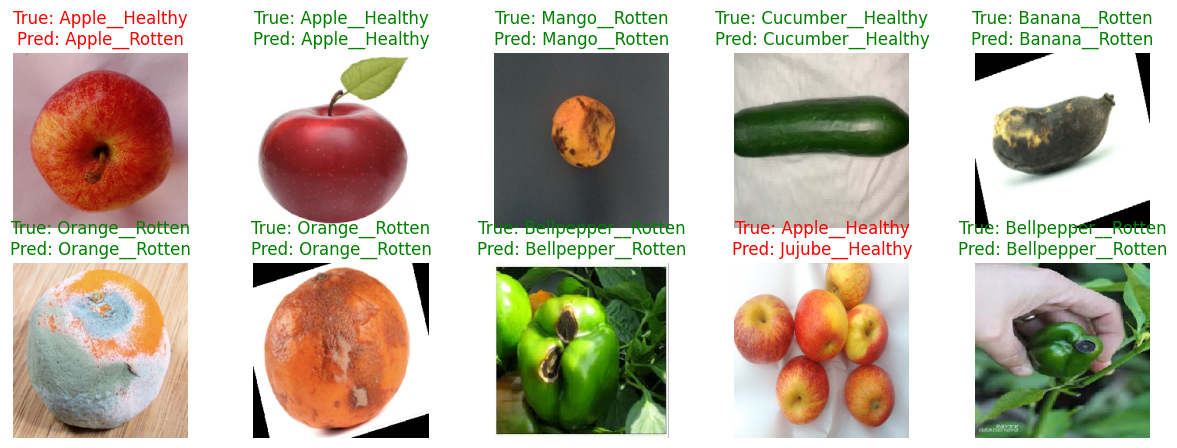

In [105]:
# Fetch a batch from validation data
valid_data.reset()
images, labels = next(valid_data)

# Get predictions
predictions = resnet_model.predict(images)

# Convert outputs to predicted classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display images with predictions
plt.figure(figsize=(15, 5))
for i in range(10):  # Display first 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = list(valid_data.class_indices.keys())[true_classes[i]]
    pred_label = list(valid_data.class_indices.keys())[predicted_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


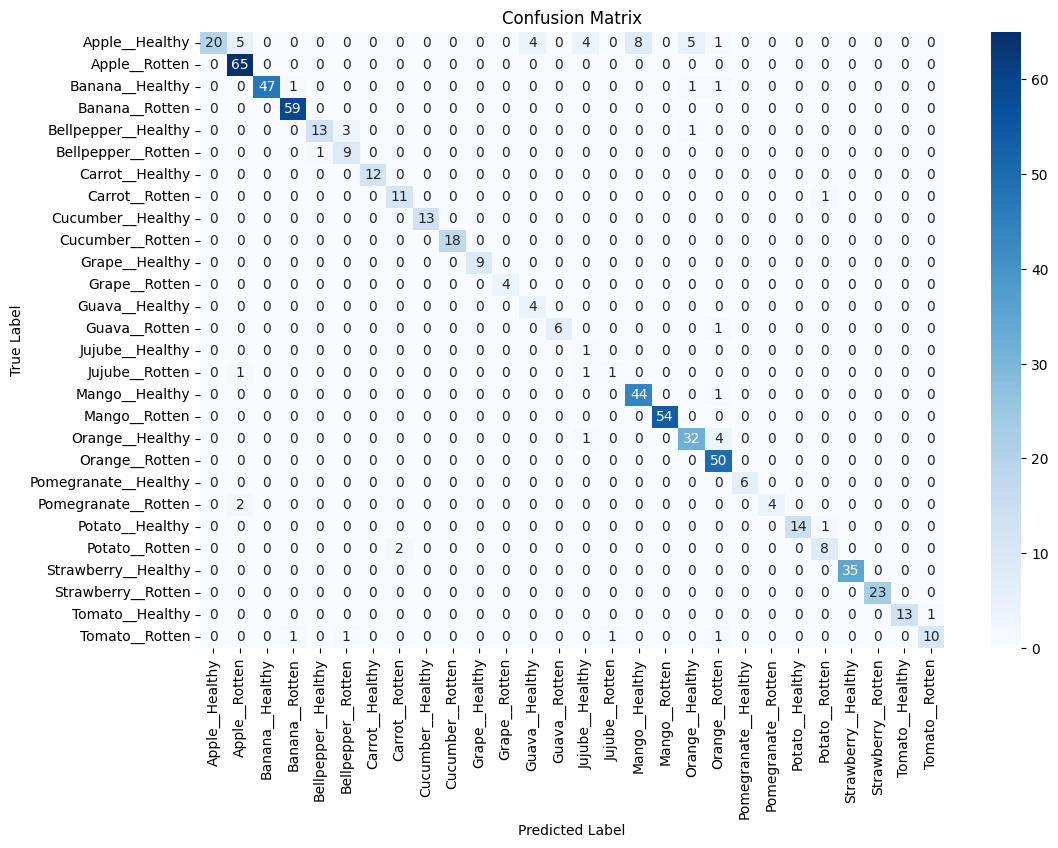

                      precision    recall  f1-score   support

      Apple__Healthy       1.00      0.43      0.60        47
       Apple__Rotten       0.89      1.00      0.94        65
     Banana__Healthy       1.00      0.94      0.97        50
      Banana__Rotten       0.97      1.00      0.98        59
 Bellpepper__Healthy       0.93      0.76      0.84        17
  Bellpepper__Rotten       0.69      0.90      0.78        10
     Carrot__Healthy       1.00      1.00      1.00        12
      Carrot__Rotten       0.85      0.92      0.88        12
   Cucumber__Healthy       1.00      1.00      1.00        13
    Cucumber__Rotten       1.00      1.00      1.00        18
      Grape__Healthy       1.00      1.00      1.00         9
       Grape__Rotten       1.00      1.00      1.00         4
      Guava__Healthy       0.50      1.00      0.67         4
       Guava__Rotten       1.00      0.86      0.92         7
     Jujube__Healthy       0.14      1.00      0.25         1
      J

In [144]:
# Limit the number of batches processed to prevent high memory usage
num_batches = 10  # Number of batches to process

y_pred_probs = []
y_true = []

# Fetch a limited number of batches from valid_data
for i, (images, labels) in enumerate(valid_data):
    if i >= num_batches:  # Restrict processing to 10 batches
        break
    preds = resnet_model.predict(images)
    y_pred_probs.append(preds)
    y_true.append(labels)

# Concatenate all batches
y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Compute predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display classification report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [145]:
# Compute error rate for each class
errors_per_class = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
error_rate_per_class = errors_per_class / np.sum(conf_matrix, axis=1)

# Display classes with the highest error rate
sorted_errors = sorted(zip(class_names, error_rate_per_class), key=lambda x: x[1], reverse=True)
print("📌 Classes with the highest error rate:")
for cls, error in sorted_errors[:5]:  # Show top 5 misclassified classes
    print(f"{cls}: {error:.2%} error")


📌 Classes with the highest error rate:
Jujube__Rotten: 66.67% error
Apple__Healthy: 57.45% error
Pomegranate__Rotten: 33.33% error
Tomato__Rotten: 28.57% error
Bellpepper__Healthy: 23.53% error


# 6. Building the MobileNetV2 Model 🔥

<div style="background: linear-gradient(135deg, #0f2027, #203a43); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #00d4ff; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        ⚡ MobileNetV2: Lightweight & Efficient
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        <strong>MobileNetV2</strong> is a fast and efficient deep learning model optimized for <strong>mobile devices</strong> and 
        <strong>low-power applications</strong>. It features depthwise separable convolutions and an inverted residual structure, 
        making it ideal for real-time classification tasks.
    </p>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; margin-top: 10px;">
        ✅ Key Features:
    </p>
    <ul style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6; list-style: none; padding: 0;">
        <li>📱 <strong>Mobile-Optimized</strong> → Designed for on-device AI</li>
        <li>⚡ <strong>High Speed</strong> → Faster inference & lower latency</li>
        <li>🧠 <strong>Pretrained on ImageNet</strong> → Excellent feature extraction</li>
        <li>🔋 <strong>Efficient</strong> → Low computational cost & memory footprint</li>
    </ul>
</div>


<div style="background: linear-gradient(135deg, #34495e, #2c3e50); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <h2 style="color: #f1c40f; font-family: 'Helvetica Neue', sans-serif; text-align: center; font-size: 26px; margin-bottom: 15px;">
        🔧 MobileNetV2 Without Fine-Tuning
    </h2>
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        Fine-tuning wasn't applied to <strong>MobileNetV2</strong> in this setup, as the results were already satisfactory. 
        However, if needed, you can enable fine-tuning to further refine the model’s performance.
    </p>
</div>

In [120]:
# Base Model: MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, 
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Model Input
inputs = layers.Input(shape=(None, None, 3))
x = layers.Resizing(224, 224)(inputs)  # ✅ Resizing applied

# Passing through MobileNetV2
x = base_model(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)  
outputs = layers.Dense(28, activation='softmax')(x)

# Build the Model
mobilenet_model = models.Model(inputs, outputs)

# Compile the Model
mobilenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.AdamW(learning_rate=5e-5),
    metrics=['accuracy']
)

# Model Summary
mobilenet_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_3 (Resizing)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 28)                  │          14,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,928,220 (11.17 MB)

 Trainable params: 670,236 (2.56 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 6.1  Training MobileNetV2 for Efficient Image Classification 📌

In [121]:
history_MobileNet = mobilenet_model.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 267s 745ms/step - accuracy: 0.4000 - loss: 2.2385 - val_accuracy: 0.8202 - val_loss: 0.7022
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 232s 666ms/step - accuracy: 0.8198 - loss: 0.6598 - val_accuracy: 0.8762 - val_loss: 0.4488
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 230s 660ms/step - accuracy: 0.8840 - loss: 0.4182 - val_accuracy: 0.8923 - val_loss: 0.3759
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 239s 685ms/step - accuracy: 0.9072 - loss: 0.3255 - val_accuracy: 0.8973 - val_loss: 0.3446
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 231s 661ms/step - accuracy: 0.9272 - loss: 0.2624 - val_accuracy: 0.9093 - val_loss: 0.3088


## 6.2  Model Performance: Accuracy, Errors & Insights 📊

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


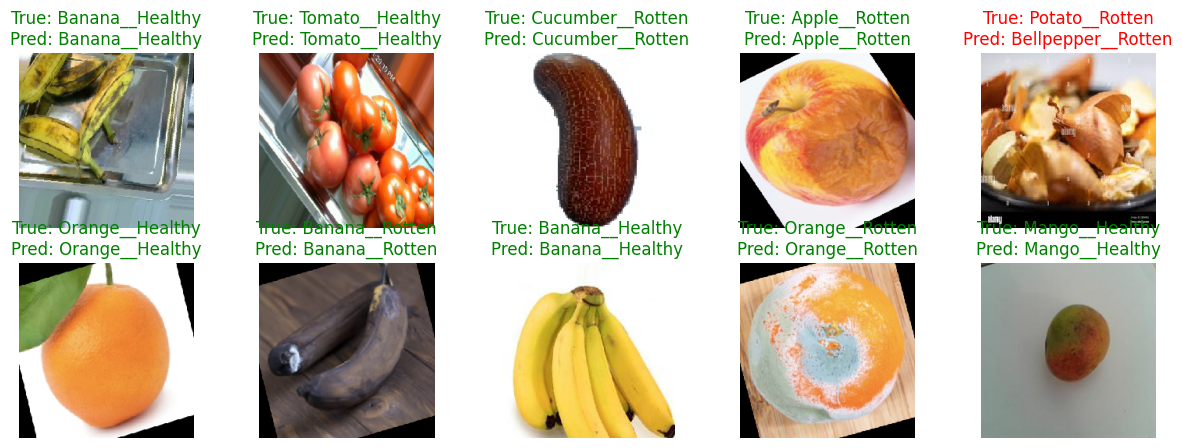

In [122]:
# Fetch a batch from the validation dataset
valid_data.reset()
images, labels = next(valid_data)

# Obtain predictions
predictions = mobilenet_model.predict(images)

# Convert outputs to predicted classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Display images along with predictions
plt.figure(figsize=(15, 5))
for i in range(10):  # Display the first 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = list(valid_data.class_indices.keys())[true_classes[i]]
    pred_label = list(valid_data.class_indices.keys())[predicted_classes[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


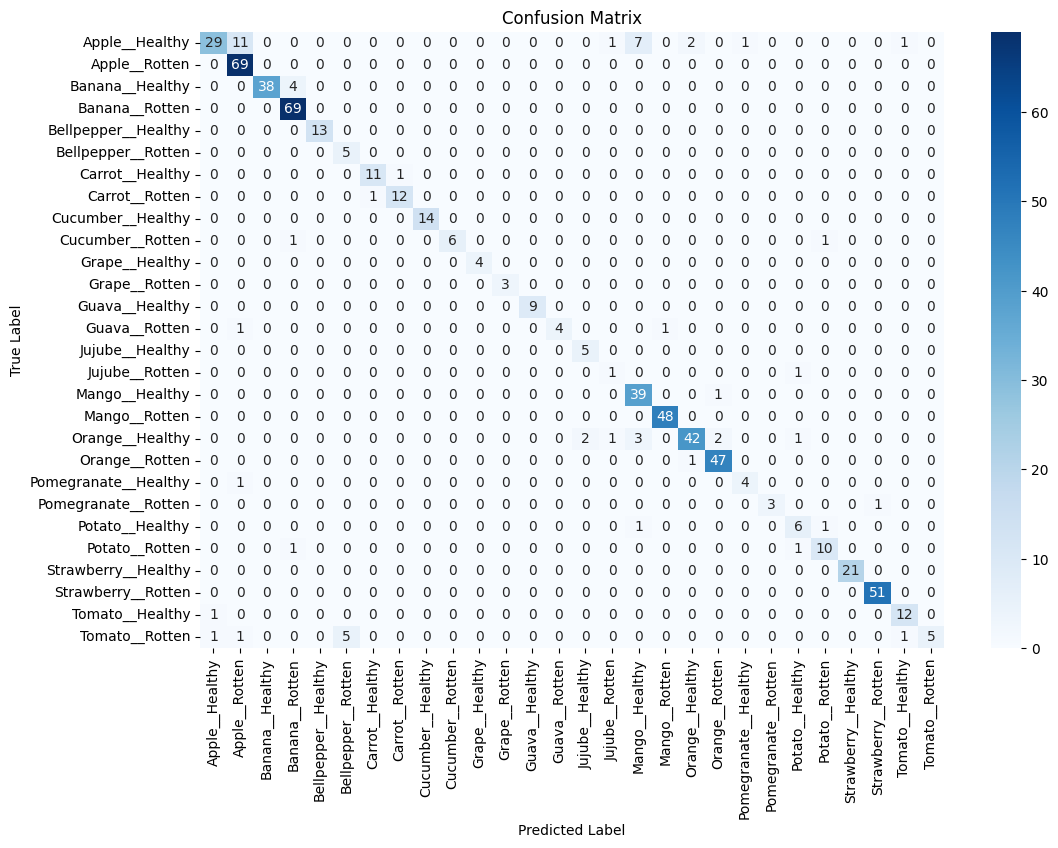

                      precision    recall  f1-score   support

      Apple__Healthy       0.94      0.56      0.70        52
       Apple__Rotten       0.83      1.00      0.91        69
     Banana__Healthy       1.00      0.90      0.95        42
      Banana__Rotten       0.92      1.00      0.96        69
 Bellpepper__Healthy       1.00      1.00      1.00        13
  Bellpepper__Rotten       0.50      1.00      0.67         5
     Carrot__Healthy       0.92      0.92      0.92        12
      Carrot__Rotten       0.92      0.92      0.92        13
   Cucumber__Healthy       1.00      1.00      1.00        14
    Cucumber__Rotten       1.00      0.75      0.86         8
      Grape__Healthy       1.00      1.00      1.00         4
       Grape__Rotten       1.00      1.00      1.00         3
      Guava__Healthy       1.00      1.00      1.00         9
       Guava__Rotten       1.00      0.67      0.80         6
     Jujube__Healthy       0.71      1.00      0.83         5
      J

In [143]:
# Limit the number of processed batches to prevent excessive memory usage
num_batches = 10  # Number of batches to process

y_pred_probs = []
y_true = []

# Fetch a limited number of batches from valid_data
for i, (images, labels) in enumerate(valid_data):
    if i >= num_batches:  # Restrict processing to 10 batches
        break
    preds = mobilenet_model2.predict(images)
    y_pred_probs.append(preds)
    y_true.append(labels)

# Concatenate all batches
y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Compute predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Compute the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display classification report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [142]:
# Compute the error rate for each class
errors_per_class = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)  # Total misclassified instances per class
error_rate_per_class = errors_per_class / np.sum(conf_matrix, axis=1)  # Error rate per class

# Sort classes based on the highest error rate
sorted_errors = sorted(zip(class_names, error_rate_per_class), key=lambda x: x[1], reverse=True)

# Display the top 5 classes with the highest error rates
print("📌 Classes with the highest error rates:")
for cls, error in sorted_errors[:5]:  # Show the top 5 most misclassified classes
    print(f"{cls}: {error:.2%} error rate")

📌 Classes with the highest error rates:
Tomato__Rotten: 60.00% error rate
Pomegranate__Healthy: 50.00% error rate
Tomato__Healthy: 28.57% error rate
Potato__Rotten: 23.08% error rate
Jujube__Rotten: 20.00% error rate


----------------------

#  Thanks for Checking Out My Code! 🚀

<div style="background: linear-gradient(135deg, #1a1a2e, #16213e); padding: 25px; border-radius: 12px; box-shadow: 0 8px 16px rgba(0, 0, 0, 0.3); margin-top: 20px;">
    <p style="color: #ecf0f1; font-family: 'Helvetica Neue', sans-serif; font-size: 16px; text-align: center; line-height: 1.6;">
        I really appreciate you taking the time to go through my work! 💡  
        If you found it helpful or have any suggestions, feel free to drop a comment.  
        Let’s keep pushing the boundaries of AI together! 🚀🔥
    </p>
</div>
